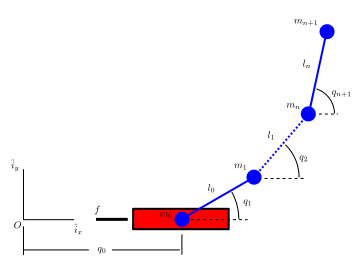

In [1]:
from IPython.display import SVG
SVG(filename='examples/npendulum/n-pendulum-with-cart.svg')

In [2]:
from pydy.models import n_link_pendulum_on_cart
import sympy as sym
import numpy as np
sym.physics.mechanics.init_vprinting(use_latex='png')

In [3]:
n = 6
sys = n_link_pendulum_on_cart(n)

/Users/aaronmeurer/Documents/python/sympy/sympy/sympy/physics/mechanics/kane.py:718: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


Pendulum arms upright, no velocities.

In [4]:
sys.initial_conditions = {k: i for k, i in zip(sys.states,
                                    np.hstack((0.0,            # q0
                                    np.pi / 2 * np.ones(n),    # q1...qn+1
                                    0 * np.ones(n+1))))}    # u0...un+1

In [5]:
arm_length = 1./n
sys.constants = {k: 1 for k in sys.constants_symbols}
for i in range(n):
    sys.constants[sym.Symbol('l%d' % i)] = arm_length
sys.constants[sym.Symbol('g')] = 9.8

Give a small "bump" force on the cart.

In [6]:
sys.specifieds = {k: lambda x, t: 1e-3 if t < 0.01 else 0 for k in sys.specifieds_symbols}

In [7]:
sys.times = np.linspace(0, 10, 1000)

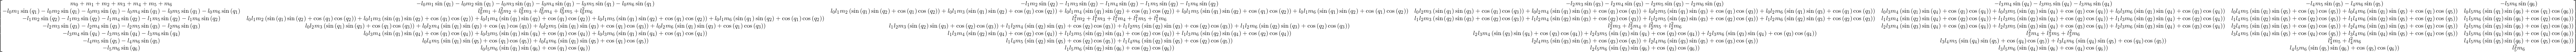

In [8]:
sys.eom_method.mass_matrix

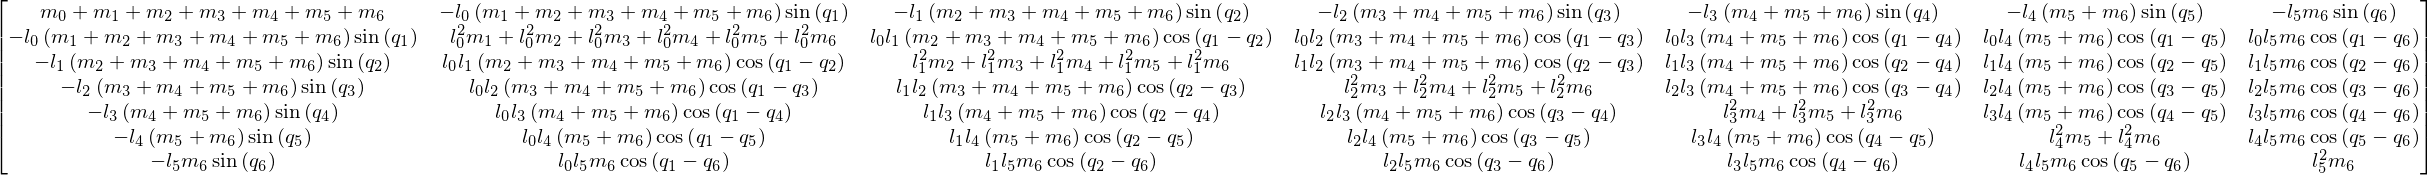

In [9]:
sym.trigsimp(sys.eom_method.mass_matrix)

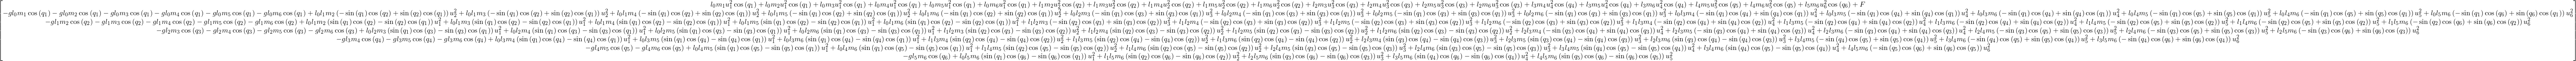

In [10]:
sys.eom_method.forcing

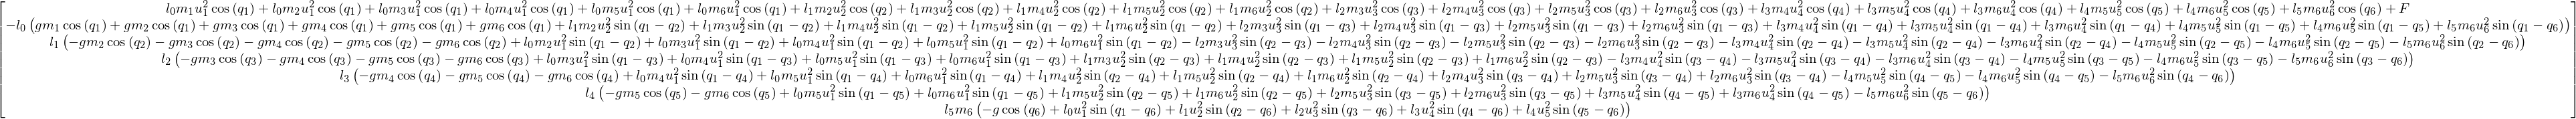

In [11]:
sym.trigsimp(sys.eom_method.forcing)

In [12]:
sys.generate_ode_function(generator="cython")
x = sys.integrate()

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(8.0, 6.0)

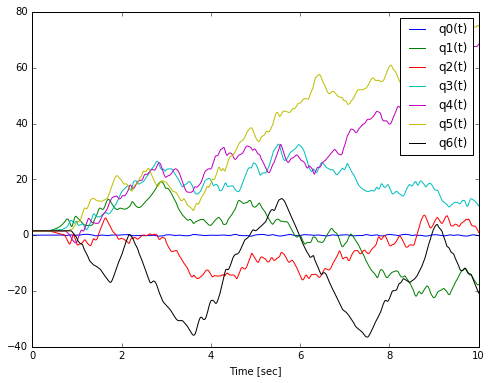

In [14]:
lines = plt.plot(sys.times, x[:, :x.shape[1] // 2])
lab = plt.xlabel('Time [sec]')
leg = plt.legend(sys.states[:x.shape[1] // 2])

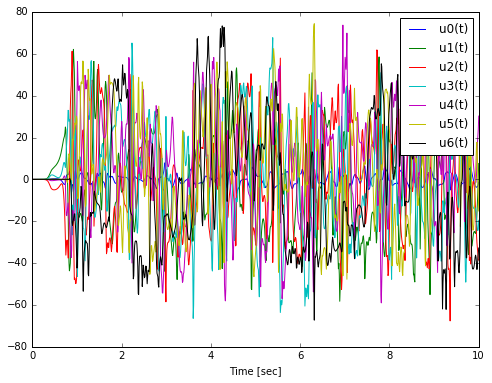

In [15]:
lines = plt.plot(sys.times, x[:, x.shape[1] // 2:])
lab = plt.xlabel('Time [sec]')
leg = plt.legend(sys.states[x.shape[1] // 2:])

In [16]:
from matplotlib import animation
from matplotlib.patches import Rectangle

In [17]:
def animate_pendulum(t, states, length, filename=None):
    """Animates the n-pendulum and optionally saves it to file.

    Parameters
    ----------
    t : ndarray, shape(m)
        Time array.
    states: ndarray, shape(m,p)
        State time history.
    length: float
        The length of the pendulum links.
    filename: string or None, optional
        If true a movie file will be saved of the animation. This may take some time.

    Returns
    -------
    fig : matplotlib.Figure
        The figure.
    anim : matplotlib.FuncAnimation
        The animation.

    """
    # the number of pendulum bobs
    numpoints = states.shape[1] // 2
    
    # first set up the figure, the axis, and the plot elements we want to animate
    fig = plt.figure()
    
    # some dimesions
    cart_width = 0.4
    cart_height = 0.2
    
    # set the limits based on the motion
    xmin = np.around(states[:, 0].min() - cart_width / 2.0, 1)
    xmax = np.around(states[:, 0].max() + cart_width / 2.0, 1)
    
    # create the axes
    ax = plt.axes(xlim=(xmin, xmax), ylim=(-1.1, 1.1), aspect='equal')
    
    # display the current time
    time_text = ax.text(0.04, 0.9, '', transform=ax.transAxes)
    
    # create a rectangular cart
    rect = Rectangle([states[0, 0] - cart_width / 2.0, -cart_height / 2],
                     cart_width, cart_height, fill=True, color='red',
                     ec='black')
    ax.add_patch(rect)
    
    # blank line for the pendulum
    line, = ax.plot([], [], lw=2, marker='o', markersize=6)

    # initialization function: plot the background of each frame
    def init():
        time_text.set_text('')
        rect.set_xy((0.0, 0.0))
        line.set_data([], [])
        return time_text, rect, line,

    # animation function: update the objects
    def animate(i):
        time_text.set_text('time = {:2.2f}'.format(t[i]))
        rect.set_xy((states[i, 0] - cart_width / 2.0, -cart_height / 2))
        x = np.hstack((states[i, 0], np.zeros((numpoints - 1))))
        y = np.zeros((numpoints))
        for j in np.arange(1, numpoints):
            x[j] = x[j - 1] + length * np.cos(states[i, j])
            y[j] = y[j - 1] + length * np.sin(states[i, j])
        line.set_data(x, y)
        return time_text, rect, line,

    # call the animator function
    anim = animation.FuncAnimation(fig, animate, frames=len(t), init_func=init,
            interval=t[-1] / len(t) * 1000, blit=True, repeat=False)
    
    # save the animation if a filename is given
    if filename is not None:
        anim.save(filename, fps=60, codec='libx264')

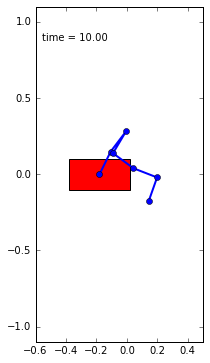

In [18]:
animate_pendulum(sys.times, x, arm_length, filename="open-loop-%s.mp4" % n)
from IPython.display import HTML
html = \
"""
<video width="640" height="480" controls>
  <source src="open-loop-%s.mp4" type="video/mp4">
Your browser does not support the video tag.
</video>
""" % n
HTML(html)

# Linearized Controller

In [19]:
equilibrium_point = [sym.S(0)] + [sym.pi / 2]*n + [sym.S(0)]*(n + 1)  
equilibrium_dict = dict(zip(sys.states, equilibrium_point))
M, F_A, F_B, r = sys.eom_method.linearize(new_method=True, op_point=equilibrium_dict)
M_num = sym.matrix2numpy(M.subs(sys.constants), dtype=float)
F_A_num = sym.matrix2numpy(F_A.subs(sys.constants), dtype=float)
F_B_num = sym.matrix2numpy(F_B.subs(sys.constants), dtype=float)

In [20]:
A = np.linalg.solve(M_num, F_A_num)
B = np.linalg.solve(M_num ,F_B_num)
equilibrium_point = np.asarray([x.evalf() for x in equilibrium_point], dtype=float)

In [21]:
import scipy.linalg
X = scipy.linalg.solve_continuous_are(A, B, np.eye(A.shape[0]), np.eye(B.shape[1]));
K = np.dot(B.T, X);

In [22]:
sys.specifieds = {k: lambda x, t: np.dot(K, equilibrium_point - x) for k in sys.specifieds_symbols}

Start a little offset

In [23]:
sys.initial_conditions = {k: i for k, i in zip(sys.states,
                                    np.hstack((0.0,           # q0
                                     np.pi*0.55,               # q1
                                    (np.pi/2) * np.ones(n-1),    # q2...qn+1
                                    0 * np.ones(n+1))))}    # u0...un+1

In [24]:
x = sys.integrate()

/Users/aaronmeurer/anaconda3/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [25]:
lines = plt.plot(sys.times, x[:, :x.shape[1] // 2])
lab = plt.xlabel('Time [sec]')
leg = plt.legend(sys.states[:x.shape[1] // 2])

/Users/aaronmeurer/anaconda3/lib/python3.5/site-packages/matplotlib/path.py:219: RuntimeWarning: invalid value encountered in isfinite
  self._has_nonfinite = not np.isfinite(self._vertices).all()
/Users/aaronmeurer/anaconda3/lib/python3.5/site-packages/matplotlib/ticker.py:1424: RuntimeWarning: invalid value encountered in double_scalars
  extra_bins = int(divmod((best_vmax - vmax), step)[0])


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x110f2d598> (for post_execute):


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

In [ ]:
lines = plt.plot(sys.times, x[:, x.shape[1] // 2:])
lab = plt.xlabel('Time [sec]')
leg = plt.legend(sys.states[x.shape[1] // 2:])

In [ ]:
animate_pendulum(sys.times, x, arm_length, filename="closed-loop-%s.mp4" % n)
html = \
"""
<video width="640" height="480" controls>
  <source src="closed-loop-%s.mp4" type="video/mp4">
Your browser does not support the video tag.
</video>
""" % n
HTML(html)

# PyDy visualization

Use the PyDy visualization. This doesn't work.

In [ ]:
from sympy import pi
from pydy.viz import (Scene, VisualizationFrame, Cube, Sphere, Cylinder,
                      PerspectiveCamera)

def pydy_n_link_pendulum_scene(sys):

    inertial_frame = sys.eom_method._inertial

    particles = sys.eom_method.bodylist

    cart_point = particles[0].point

    for p in cart_point._pos_dict.keys():
        if p.name == 'O':
            origin = p

    for c in sys.constants.keys():
        if c.name.startswith('l'):
            length = c
            break

    cart_shape = Cube(0.3, color='red')
    joint_shape = Sphere(color='blue', radius=0.1)
    link_shape = Cylinder(length, 0.05, color='blue')

    viz_frames = [VisualizationFrame(inertial_frame, cart_point,
                                     cart_shape)]

    for i, particle in enumerate(particles):
        viz_frames.append(VisualizationFrame(inertial_frame, particle,
                                             joint_shape))

        if i != len(particles) - 1:
            vec = particle.point.pos_from(particles[i + 1].point).normalize()
            mid_point = particle.point.locatenew('mid', -length / 2 * vec)

            for frame in inertial_frame._dcm_dict.keys():
                if frame.name.endswith(str(i)):
                    break

            rot_frame = frame.orientnew('eee', 'Axis', [pi / 2, frame.z])

            viz_frames.append(VisualizationFrame(rot_frame, mid_point,
                                                 link_shape))

    # TODO : This should cause the camera to follow the cart, but it doesn't
    # seem to be working. Also, if OrthoGraphicCamera is used, it rotates
    # the inertial frame's axes and it is super zoomed out.
    camera_point = cart_point.locatenew('Camera Location', 30 *
                                        inertial_frame.z)
    primary_camera = PerspectiveCamera(inertial_frame, camera_point)

    scene = Scene(inertial_frame, origin, *viz_frames)

    scene.cameras = [primary_camera]
    scene.constants = sys.constants
    scene.states_symbols = sys.states

    return scene

In [ ]:
scene = pydy_n_link_pendulum_scene(sys)
scene.states_trajectories = x

In [ ]:
scene.display_ipython()